In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

## Data Preparation
### Content
The Book-Crossing dataset comprises 3 files.

- Users<br>
Contains the users. Note that user IDs `(User-ID)` have been anonymized and map to integers. Demographic data is provided (`Location`, `Age`) if available. Otherwise, these fields contain NULL-values.


- Books<br>
Books are identified by their respective ISBN. Invalid ISBNs have already been removed from the dataset. Moreover, some content-based information is given (`Book-Title`, `Book-Author`, `Year-Of-Publication`, `Publisher`), obtained from Amazon Web Services. Note that in case of several authors, only the first is provided. URLs linking to cover images are also given, appearing in three different flavours (`Image-URL-S`, `Image-URL-M`, `Image-URL-L`), i.e., small, medium, large. These URLs point to the Amazon web site.


- Ratings<br>
Contains the book rating information. Ratings (Book-Rating) are either explicit, expressed on a scale from 1-10 (higher values denoting higher appreciation), or implicit, expressed by 0.

In [58]:
Ratings = pd.read_csv('Ratings.csv')
Users = pd.read_csv('Users.csv')
Books = pd.read_csv('Books.csv')

In [59]:
Books.head(1)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...


In [60]:
Users.head(1)

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN


In [61]:
Ratings.head(1)

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0


## EDA

In [62]:
# Checking shape of all 3 dataSets
print('Shape of Books = ',Books.shape)
print('Shape of Users = ',Users.shape)
print('Shape of Ratings = ',Ratings.shape)

Shape of Books =  (271360, 8)
Shape of Users =  (278858, 3)
Shape of Ratings =  (1149780, 3)


In [63]:
# Checking null values of Books dataset
Books.isnull().sum()

ISBN                   0
Book-Title             0
Book-Author            1
Year-Of-Publication    0
Publisher              2
Image-URL-S            0
Image-URL-M            0
Image-URL-L            3
dtype: int64

Our main feature is `Book-Title` and it doesnot contain any null values.

In [64]:
# Checking null values of Users dataset
Users.isnull().sum()

User-ID          0
Location         0
Age         110762
dtype: int64

Our main feature is `User-ID` and it doesnot contain any null values.

In [65]:
# Checking null values of Ratings dataset
Ratings.isnull().sum()

User-ID        0
ISBN           0
Book-Rating    0
dtype: int64

In [5]:
# Mergint Rating & Books file on basis of ISBN
Rating_with_name = Ratings.merge(Books,on='ISBN')
Rating_with_name.head(1)

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,276725,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...


In [66]:
Number_of_users = Rating_with_name['User-ID'].nunique()
Number_of_books = Rating_with_name['Book-Title'].nunique()
Number_of_ratings = Rating_with_name.shape[0]
print('Total Number of Users giving rating = ',Number_of_users)
print('Total Number of Books get reviewed = ',Number_of_books)
print('Total Number of ratings = ',Number_of_ratings)

Total Number of Users giving rating =  92106
Total Number of Books get reviewed =  241071
Total Number of ratings =  1031136


Let's check per rating (1-10) number of rating counts

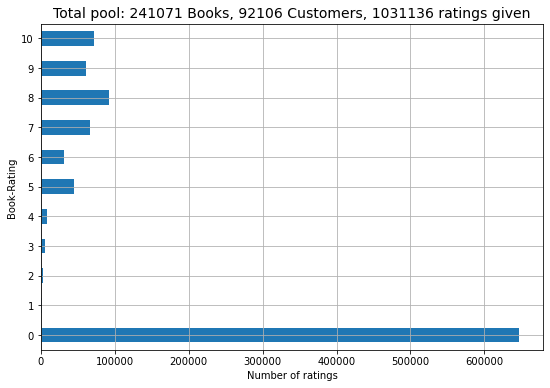

In [67]:
# stars gives number of ratings of individual rating (1-10)
stars=Rating_with_name.groupby('Book-Rating')['Book-Rating'].agg(['count'])

ax=stars.plot(kind='barh', legend=False, figsize=(9,6))
plt.xlabel('Number of ratings')
plt.title(f'Total pool: {Number_of_books} Books, {Number_of_users} Customers, {Number_of_ratings} ratings given', fontsize=14)
plt.grid(True)

Most of the books are not rated. Let's check distribution avg-rating and number of ratings of every books

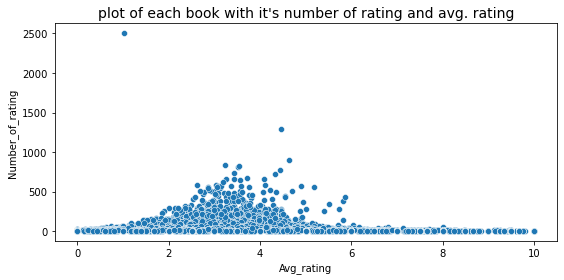

In [68]:
# book_by_rating gives per Book wise average rating and total number of ratings
book_by_rating = Rating_with_name.groupby('Book-Title').agg(Avg_rating = ('Book-Rating', 'mean'),
                                                          Number_of_rating = ('Book-Rating','count')).reset_index()

#Plotting the scatterplot 
plt.figure(figsize=(9,4))
sns.scatterplot(x='Avg_rating', y='Number_of_rating', data=book_by_rating)
plt.title('plot of each book with it\'s number of rating and avg. rating', fontsize=14)
plt.show()

Avg. rating is $<4$. This is because most of the users do not rate.Let's remove those users who do not give rating.

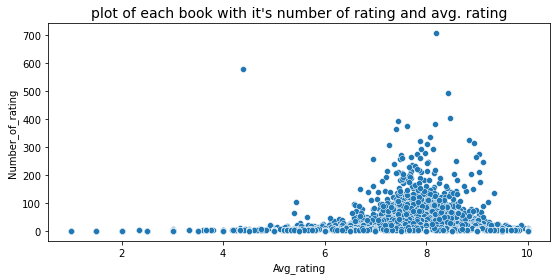

In [69]:
# Rated_no_0 removes all details of 0 rating
Rated_no_0 = Rating_with_name[Rating_with_name['Book-Rating']!=0]

# book_by_rating_no_0 gives per Book wise average rating and total number of ratings
book_by_rating_no_0 = Rated_no_0.groupby('Book-Title').agg(Avg_rating = ('Book-Rating', 'mean'),
                                                          Number_of_rating = ('Book-Rating','count')).reset_index()

#Plotting the scatterplot 
plt.figure(figsize=(9,4))
sns.scatterplot(x='Avg_rating', y='Number_of_rating', data=book_by_rating_no_0)
plt.title('plot of each book with it\'s number of rating and avg. rating', fontsize=14)
plt.show()

Now avg. rating is arround $7-9$.

In [70]:
print(f'''Among {Rating_with_name.shape[0]} of ratings only {Rated_no_0.shape[0]} number of ratings are non-zero.
Therefore rating % = {round(Rated_no_0.shape[0]/Rating_with_name.shape[0]*100,2)}%''')

Among 1031136 of ratings only 383842 number of ratings are non-zero.
Therefore rating % = 37.23%


## Popularity Based Recommendation System
Popularity Based Reommendation System refers to those books which achieve Top 50 rank in numbers of ratings

In [71]:
# Popular_book refers to those which collect atleast 250 numbers of ratings
Popular_book = book_by_rating[book_by_rating['Number_of_rating']>250].sort_values(by='Avg_rating',ascending=False)

# Top_50_book refers to those 50 Popular books which have highest average rating
Top_50_book = Popular_book.head(50)
Top_50_book.head()

,Book-Title,Avg_rating,Number_of_rating
80434,Harry Potter and the Prisoner of Azkaban (Book 3),5.852804,428
80422,Harry Potter and the Goblet of Fire (Book 4),5.824289,387
80441,Harry Potter and the Sorcerer's Stone (Book 1),5.737410,278
80426,Harry Potter and the Order of the Phoenix (Boo...,5.501441,347
80414,Harry Potter and the Chamber of Secrets (Book 2),5.183453,556


From above list it is shown that **Harry Potter Series** is in top 5 list.

In [72]:
# Top_50_book_with_detail gives detail of Top-50 books
Top_50_book_with_detail = Top_50_book.merge(Books,on='Book-Title').drop_duplicates('Book-Title').drop(['ISBN','Image-URL-S','Image-URL-L'],axis=1)
Top_50_book_with_detail.head(3)

,Book-Title,Avg_rating,Number_of_rating,Book-Author,Year-Of-Publication,Publisher,Image-URL-M
0,Harry Potter and the Prisoner of Azkaban (Book 3),5.852804,428,J. K. Rowling,1999,Scholastic,http://images.amazon.com/images/P/0439136350.0...
3,Harry Potter and the Goblet of Fire (Book 4),5.824289,387,J. K. Rowling,2000,Scholastic,http://images.amazon.com/images/P/0439139597.0...
5,Harry Potter and the Sorcerer's Stone (Book 1),5.737410,278,J. K. Rowling,1998,Scholastic,http://images.amazon.com/images/P/0590353403.0...


 ## Colaborative Based recommendation system
 Collaborative filtering is based on the assumption that people who agreed in the past will agree in the future, and that they will like similar kinds of items as they liked in the past. The system generates recommendations using only information about rating profiles for different users or items. By locating peer users/items with a rating history similar to the current user or item, they generate recommendations using this neighborhood. Collaborative filtering methods are classified as `memory-based` and `model-based`
 ### memory-based filtering
 #### Item-based filtering

In [73]:
# valid_users are those who atleast give rating more than 200 books
valid_users = Rating_with_name.groupby('User-ID').count()['Book-Rating']>200
# Boolean indexing to get index of valid users
valid_users_index = valid_users[valid_users].index
# Filtering user-book detail based on valid_users_index
filtered_user_rating = Rating_with_name[Rating_with_name['User-ID'].isin(valid_users_index)].drop_duplicates()
print('Only top',len(valid_users_index),'number of users give',filtered_user_rating.shape[0],
      'number of rating. \nThrefore average number of rating per top users=',
      round(filtered_user_rating.shape[0]/len(valid_users_index),2))

Only top 811 number of users give 474007 number of rating. 
Threfore average number of rating per top users= 584.47


In [74]:
# valid_books are those which get atleast 100 reviews/ratings
valid_books = filtered_user_rating.groupby('Book-Title').count()['Book-Rating']>=50
# Boolean indexing to get index of valid books
valid_books_index = valid_books[valid_books].index
# Finally we filter valid user-book detail based on valid_books_index
final_filter = filtered_user_rating[filtered_user_rating['Book-Title'].isin(valid_books_index)].drop_duplicates()
print('Out of ',filtered_user_rating.shape[0],'number of rating only',
      len(valid_books_index),'number of books get',final_filter.shape[0],
      'number of ratings.\nTherefore average number of rating got by top rated books=',
      np.round(final_filter.shape[0]/len(valid_books_index),2))

Out of  474007 number of rating only 706 number of books get 58586 number of ratings.
Therefore average number of rating got by top rated books= 82.98


In [75]:
#creating the user-item interaction matrix
Book_matrix_UII = final_filter.pivot_table(index='Book-Title',columns='User-ID',values='Book-Rating').fillna(0)
Book_matrix_UII.head()

User-ID,254,2276,2766,2977,3363,4017,4385,6251,6323,6543,...,271705,273979,274004,274061,274301,274308,275970,277427,277639,278418
Book-Title,,,,,,,,,,,,,,,,,,,,,
1984,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1st to Die: A Novel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2nd Chance,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4 Blondes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A Bend in the Road,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [76]:
print(f'''Shape of the user-item interaction matrix is {Book_matrix_UII.shape}. 
Where {Book_matrix_UII.shape[0]} is number of unique books and {Book_matrix_UII.shape[1]} is number of unique users.''')

Shape of the user-item interaction matrix is (706, 810). 
Where 706 is number of unique books and 810 is number of unique users.


In [77]:
# Calculating similarity score
similarity_score = cosine_similarity(Book_matrix_UII)

In [78]:
def recommended(book_name):
    # index gives index position of book_name
    index = np.where(Book_matrix_UII.index==book_name)[0][0]
    # similar_book gives top list of top-5 book's index & similarity score
    similar_book = sorted(list(enumerate(similarity_score[index])),key=lambda x:x[1],reverse=True)[1:6]
    for index,similarity in similar_book:
        # Book_matrix_UII.index stores all books name so I want to fetch book_name unsing index of similar_book
        print(Book_matrix_UII.index[index],' = ',similarity)

In [79]:
recommended('1st to Die: A Novel')

Along Came a Spider (Alex Cross Novels)  =  0.3074664764749361
Roses Are Red (Alex Cross Novels)  =  0.2827397366387593
Pop Goes the Weasel  =  0.2780357116802063
Violets Are Blue  =  0.2776809645250099
Lightning  =  0.2715497227877098


In [80]:
# Checking similarity using correlation
Book_matrix_UII.T.corr()['1st to Die: A Novel'].sort_values(ascending=False)[1:6]

Book-Title
Along Came a Spider (Alex Cross Novels)          0.280918
Roses Are Red (Alex Cross Novels)                0.259073
Pop Goes the Weasel                              0.253181
The Clinic (Alex Delaware Novels (Paperback))    0.247832
Lightning                                        0.244731
Name: 1st to Die: A Novel, dtype: float64

cosine_similarity and correlation almost give same result. Let's check another resuslt.

In [81]:
recommended('2nd Chance')

Four Blind Mice  =  0.39182763786833574
The Next Accident  =  0.34991368995007677
Violets Are Blue  =  0.30619341327105154
The Murder Book  =  0.29468927698294456
Flesh and Blood  =  0.2744597369070355


In [82]:
Book_matrix_UII.T.corr()['2nd Chance'].sort_values(ascending=False)[1:6]

Book-Title
Four Blind Mice      0.371790
The Next Accident    0.336687
Violets Are Blue     0.277350
The Murder Book      0.271235
Mortal Prey          0.252044
Name: 2nd Chance, dtype: float64

### Model based colaborative filtering
<details>
    <summary><h3>1. Model</h3></summary>


Matrix factorization (MF) supposes that each observed evaluation $r_{ui}$ for $1 \leq u \leq |U|$ and $1 \leq i \leq |I|$, where $|U|$ and $|I|$ are respectively the number of users and movies, can be estimated with respect to a latent (hidden) model. This model presents the estimate $\hat{r}_{ui}$ of the observed evaluation $r_{ui}$ as:


$$
\begin{align}
\hat{r}_{ui} =  \langle p_{u}, q_{i} \rangle, 
\end{align}
$$

where $\langle \cdot \rangle$ is the scalar product and $p_{u}$ and $q_{i}$ are the latent representations associated to user *u* and item *i*. The intuition behind this representation suggests that each evaluation can be estimated by considering a latent characterization of users and items.

For example, we could fix the number of latent variables to 3, and assume that they are associated with the popularity of the movie at the box office, its duration and finally its level of romance. If we define the user *u* as a 15-year-old teenager who loves popular and relatively short horror movies, we can model the associated latent vector by:
$$
\begin{align}
p_{u} = [1, 0, 0]^T.
\end{align}
$$

Suppose now that the movie *i* turns out to be *The Lion King* with the following latent modelization:

$$
\begin{align}
q_{i} = [1, 0.5, 0]^T.
\end{align}
$$

The evaluation's estimation for this user and this item according to the latent representations will therefore be:

$$
\begin{align}
\hat{r}_{ui} =  \langle p_u, q_i \rangle = 1.
\end{align}
$$

The main challenge with this type of model is to define the set of latent vectors associated with users, grouped in matrix form by $\mathbf{P}_{|U| \times k} = [p_1, p_2, .. ., p_k]$, and to items, grouped in matrix form by $ \mathbf{Q}_{|I| \times k} = [q_1, q_2, ..., q_k] $.
 
Since the initial problem is to present the most accurate estimates, and thus to calculate $\mathbf{P}$ and $\mathbf{Q}$ so as to minimize the distance between the totality of the observed ratings $r_{ui}$ and their estimate $\hat {r}_{ui}$, we can define the task to accomplish with the following optimization problem:

$$
\begin{align}
\mathbf{P}, \mathbf{Q} = \underset{p, q}{\operatorname{argmin}} \sum_{r_{ui} \neq 0} (r_{ui} - \hat{r}_{ui})^2 = \underset{p, q}{\operatorname{argmin}}  \sum_{r_{ui} \neq 0} (r_{ui} - \langle p_u, q_i \rangle)^2.
\end{align}
$$

We may add a regularization on the latent variables, in order to force the associated vectors to have non-zero components:

$$
\begin{align}
\mathbf{P}, \mathbf{Q} = \underset{p, q}{\operatorname{argmin}} \sum_{r_{ui} \neq 0} \{(r_{ui} - \langle p_u, q_i \rangle)^2 + \lambda(||p_u||^2 + ||q_i||^2)\},
\end{align}
$$

where $\lambda$ is the regularization hyperparameter, <i>weigth decay</i> in deep learning, or Lagrange multiplier in math. It should be noted that latent vectors with very few zero values will in turn lead to predicted ratings other than zero. Since we are trying to propose new recommendations, this constraint seems useful in avoiding a sparse matrix estimate $\hat{\mathbf{R}}$.

The optimization problem above, which turns out to factorize a sparse matrix, generally cannot be solved as easily as using the least squares in a linear regression context for example. In this tutorial, we will introduce the stochastic gradient descent algorithm, as one of the approaches in solving this optimization problem to estimate $\mathbf{P}$ and $ \mathbf{Q}$ matrices
</details>

<details>
    <summary><h3>2. Loss function</h3></summary>


The loss function plays a decisive role in the construction of a predictive model. In fact, it is this same cost function that we will try to optimize by iteratively adjusting the values of the latent matrices $\mathbf{P}$ and $\mathbf{Q}$.

Since we consider that the observed evaluations vary between 1 and 5, the mean squared error (MSE) seems like an interesting first option. From a recommender system point of view, we will define the MSE as follows:

$$
\begin{align}
MSE(\mathbf{R}, \hat{\mathbf{R}}) = \frac{1}{n} \sum_{r_{ui} \neq 0} (r_{ui} - \hat{r}_{ui})^2, 
\end{align}
$$

where $\mathbf{R}$ and $\hat{\mathbf{R}}$ are respectively the matrices of observed and predicted ratings and *n* is the number of evaluations.
### Estimation
 
The parameters' estimates are directly associated with the loss function we are trying to minimize. With matrix factorization, two estimation techniques are available to calculate the latent matrices $\mathbf{P}$ and $\mathbf{Q}$, respectively associated to users and items. In both cases, these techniques use the linearity of the matrix factorization model.
</details>
<details>
    <summary><h3>3. Gradient descent</h3></summary>
 
First, we implement stochastic gradient descent (SGD): an iterative method that reviews all non-zero evaluations for each user. While remembering that the function we are trying to minimize is:
 
$$
\begin{align}
\underset{p, q}{\operatorname{min}} L(\mathbf{R}, \lambda) = \underset{p, q}{\operatorname{min}} \sum_{r_{ui} \neq 0} \{(r_{ui} - \langle p_u, q_i \rangle)^2 + \lambda \cdot (||p_u||^2 + ||q_i||^2)\},
\end{align}
$$
 
we calculate the gradients of the previous equation as a function of $p_u$ and $q_i$:
 
$$
\nabla_{p_{u}} L(\mathbf{R}, \lambda) =  -2q_{i} \cdot \epsilon_{ui} + 2\lambda \cdot p_{u} \quad \text{and} \quad
\nabla_{q_{i}} L(\mathbf{R}, \lambda) =  -2p_{u} \cdot \epsilon_{ui} + 2\lambda \cdot q_{i},
$$
 
where we denote the error by:
 
$$
\epsilon_{ui} = r_{ui} - \hat{r}_{ui}.
$$
 
Finally, for each iteration, as long as the user-item rating is non-zero, we perform the following update on the latent vectors as follows:
 
$$
p_{u}^{(t+1)} \leftarrow p_{u}^{(t)} + \gamma \cdot (2q_{i}^{(t)} \cdot \epsilon_{ui} - 2 \lambda \cdot p_{u}^{(t)}) \\
q_{i}^{(t+1)} \leftarrow q_{i}^{(t)} + \gamma \cdot (2p_{u}^{(t)} \cdot \epsilon_{ui} - 2 \lambda \cdot q_{i}^{(t)}),
$$
 
where $ p_{u}^{(t + 1)}$ is the value of $ p_{u}$ after the $t + 1$ iteration and where $\gamma$ is the learning rate of the descent. That is, we take a step in the opposite direction of the gradients in such a way that we minimize the loss function.
</details>

In [41]:
def Matrix_factorization(data, features=10, lr=0.0002, epochs=100, weight_decay = 0.02, stopping = 0.001):
    """
    Args:
       data: every evaluation
       features: number of latent variables
       lr: learning rate for gradient descent
       epochs: number of iterations or maximum loops to perform
       weigth_decay: L2 regularization to predict rattings different of 0
       stopping: scalar associated with the stopping criterion
      
     Returns:
       P: latent matrix of users
       Q: latent matrix of items
       loss: vector of the different values of the loss function after each iteration
       """     
    nb_users, nb_items = len(data.index), len(data.columns)
    loss = []

    P = np.random.rand(nb_users,features) 
    Q = np.random.rand(nb_items,features)
    Q = Q.T
    
    for e in range(epochs):
        for u in range(nb_users):
            for i in range(nb_items):
                if data.iloc[u,i]>0:
                    error_ui = data.iloc[u,i] - np.dot(P[u,:],Q[:,i])
                    
                    # Gradient descent
                    for f in range (features):
                        P[u][f] = P[u][f] + lr * (2 * error_ui * Q[f][i] - 2 * weight_decay *  P[u][f])
                        Q[f][i] = Q[f][i] + lr * (2 * error_ui * P[u][f] - 2 * weight_decay *  Q[f][i])
           
        pred = np.dot(P,Q)
        errors_sum, nb_evaluations = 0,0
        for u in range(nb_users):
            for i in range(nb_items):
                if data.iloc[u,i]>0:
                    errors_sum += pow(data.iloc[u,i] - np.dot(P[u,:],Q[:,i]),2)
                    nb_evaluations+=1
        
        mean_error = errors_sum/nb_evaluations
        loss.append(mean_error)
        if abs(loss[-1])<stopping:
            break  
            
    return P, Q.T, loss

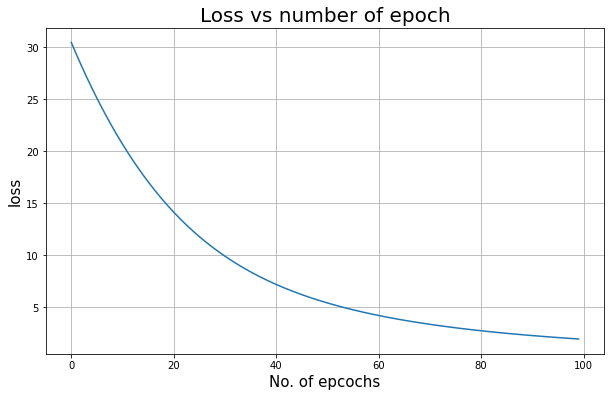

In [56]:
# creating training set
train = Book_matrix_UII.sample(n = 10)
# Trianing the model and getting P,Q,loss
P, Q, loss = Matrix_factorization(train)

# Plotting loss values against number of epochs
plt.figure(figsize=(10,6))
plt.plot(loss)
plt.xlabel('No. of epcochs',fontsize=15)
plt.ylabel('loss',fontsize=15)
plt.title('Loss vs number of epoch',fontsize=20)
plt.grid(True)

### Model building and prediction using SVD

In [18]:
#!pip install scikit-surprise
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate,train_test_split
from surprise import accuracy

In [21]:
# creating object of Reader class
reader=Reader()
# splitting the data into trainset and testset
data = Dataset.load_from_df(Rating_with_name[['User-ID','Book-Title','Book-Rating']], reader)
train, test =train_test_split(data)

In [23]:
# creating object of SVD class
svd=SVD()
# fitting the model
svd.fit(train)
# prediction
pred = svd.test(test)
# getting accuracy in RMSE
accuracy.rmse(pred, verbose=True)

RMSE: 3.5180


3.5180033892122013

In [25]:
# getting top n recommended moveis for every users
def get_top_n(predictions, n=10):
    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the n highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [27]:
top_5 = get_top_n(pred, n=5)

In [30]:
user_id, recommendation = [],[]
for uid, user_ratings in top_5.items():
    user_id.append(uid)
    recommendation.append([iid for (iid, _) in user_ratings])      

In [59]:
recommendation_matrix = pd.DataFrame({'User_ID':user_id,'To 5 recommendation':recommendation})
recommendation_matrix.head()

,User_ID,To 5 recommendation
0,123056,"[The Sixteen Pleasures: A Novel, Presumed Inno..."
1,76151,"[ONE FOR THE MONEY : A Stephanie Plum Novel, D..."
2,26544,"[High Five (A Stephanie Plum Novel), Angels &a..."
3,125411,"[The Sisterhood of the Traveling Pants, The Sc..."
4,153662,"[What Katy Did Next (Wordsworth Collection), T..."
